In [18]:
import pandas as pd
import numpy as np
import joblib
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve

# --- 1. CONFIGURATION ---
DATA_PATH = '../data/Social Media Engagement Dataset.csv'
MODEL_DIR = '../models'
MODEL_PATH = os.path.join(MODEL_DIR, 'virality_model.pkl')
METADATA_PATH = os.path.join(MODEL_DIR, 'model_metadata.pkl')

# 75th Percentile = Top 25% are considered viral
VIRAL_PERCENTILE = 0.75 
RANDOM_SEED = 42

os.makedirs(MODEL_DIR, exist_ok=True)

In [19]:
# --- 2. LOAD DATA ---
print("Loading Data...")
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    # Fallback to absolute path for debugging
    df = pd.read_csv(r'd:\projects\StudioFlowAI\backend\app\ml\data\Social Media Engagement Dataset.csv')

# Create Target Variable
threshold_val = df['impressions'].quantile(VIRAL_PERCENTILE)
df['is_viral'] = (df['impressions'] >= threshold_val).astype(int)

print(f"Viral Threshold (Impressions): {threshold_val:.0f}")
print(f"Class Distribution:\n{df['is_viral'].value_counts(normalize=True)}")

Loading Data...
Viral Threshold (Impressions): 74815
Class Distribution:
is_viral
0    0.75
1    0.25
Name: proportion, dtype: float64


In [20]:
# --- 3. PREPROCESSING ---
# Combine text features for a richer signal
df['full_text'] = df['text_content'].fillna('') + " " + df['hashtags'].fillna('')

# Select Features
text_features = 'full_text'
categorical_features = ['platform', 'topic_category']
numerical_features = ['sentiment_score', 'user_engagement_growth']

X = df[[text_features] + categorical_features + numerical_features]
y = df['is_viral']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

In [21]:
# --- 4. PIPELINE CONSTRUCTION ---
# We strictly handle missing values now

# Numeric: Impute missing with 0 -> Scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Categorical: Impute missing with 'unknown' -> OneHot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        # Text: TF-IDF (1-grams and 2-grams)
        ('text', TfidfVectorizer(max_features=2000, stop_words='english', ngram_range=(1,2)), text_features),
        # Categorical
        ('cat', categorical_transformer, categorical_features),
        # Numerical
        ('num', numeric_transformer, numerical_features)
    ]
)

# Using Random Forest as requested
clf = RandomForestClassifier(
    n_estimators=300, 
    class_weight='balanced', 
    random_state=RANDOM_SEED, 
    n_jobs=-1
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

In [23]:
# --- 5. TRAIN & OPTIMIZE THRESHOLD ---
print("Training Random Forest Model...")
model_pipeline.fit(X_train, y_train)

# Get probabilities instead of hard predictions
y_probs = model_pipeline.predict_proba(X_test)[:, 1]

# Find Optimal Threshold
print("\nOptimizing Decision Threshold...")
best_threshold = 0.5
best_f1 = 0
best_accuracy = 0

# Test thresholds from 0.1 to 0.6
for thresh in np.arange(0.1, 0.6, 0.01):
    preds = (y_probs >= thresh).astype(int)
    # We focus on the F1 score of the '1' (Viral) class
    score = f1_score(y_test, preds, pos_label=1)
    accuracy = accuracy_score(y_test, preds)
    
    if score > best_f1:
        best_f1 = score
        best_threshold = thresh
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        
    

print(f"\n🏆 Best Threshold Found: {best_threshold:.2f}")
print(f"Best Viral F1-Score: {best_f1:.4f}")
print(f"Best Viral Accuracy: {best_accuracy:.4f}")

# Final Evaluation with Custom Threshold
final_preds = (y_probs >= best_threshold).astype(int)
print("\n--- Final Classification Report ---")
print(classification_report(y_test, final_preds))

Training Random Forest Model...

Optimizing Decision Threshold...

🏆 Best Threshold Found: 0.11
Best Viral F1-Score: 0.3982
Best Viral Accuracy: 0.7496

--- Final Classification Report ---
              precision    recall  f1-score   support

           0       0.73      0.01      0.03      1800
           1       0.25      0.98      0.40       600

    accuracy                           0.26      2400
   macro avg       0.49      0.50      0.21      2400
weighted avg       0.61      0.26      0.12      2400




Analyzing Top Features...


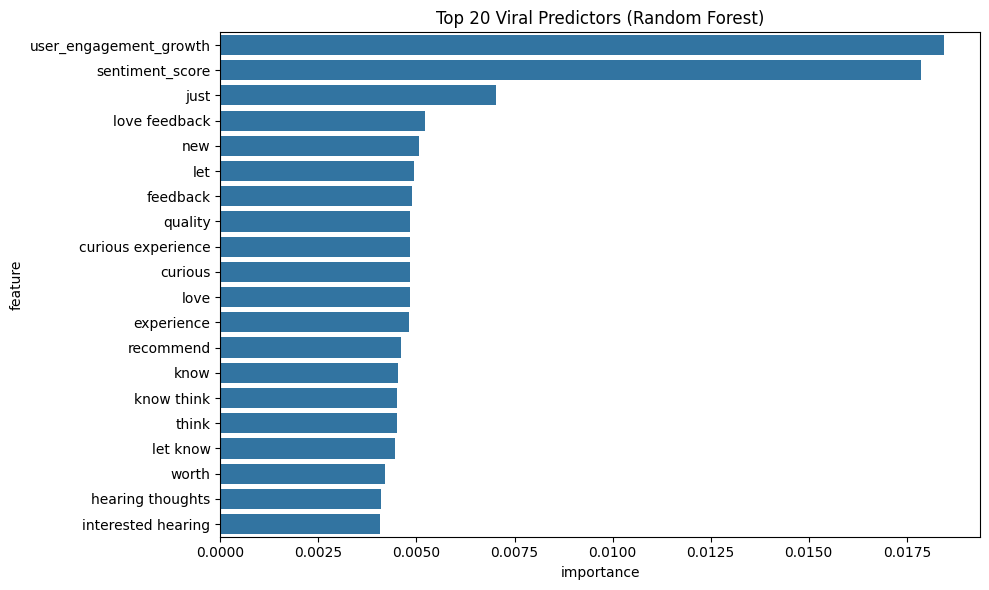

In [24]:
# --- 6. FEATURE IMPORTANCE ---
def get_feature_names(column_transformer):
    output_features = []
    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder': continue
        if hasattr(pipe, 'get_feature_names_out'):
             # For nested pipelines (categorical/numeric), we need to drill down
            if isinstance(pipe, Pipeline):
                # The step that generates feature names (e.g. onehot)
                if 'onehot' in pipe.named_steps: 
                    names = pipe.named_steps['onehot'].get_feature_names_out(features)
                else:
                    names = features # Numeric pass through
            else:
                names = pipe.get_feature_names_out(features)
        else:
            names = features
        output_features.extend(names)
    return output_features

print("\nAnalyzing Top Features...")
try:
    feature_names = get_feature_names(model_pipeline.named_steps['preprocessor'])
    importances = model_pipeline.named_steps['classifier'].feature_importances_

    feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feat_df = feat_df.sort_values('importance', ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feat_df)
    plt.title('Top 20 Viral Predictors (Random Forest)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance: {e}")

In [26]:
# --- 7. SAVE ---
print(f"Saving model to {MODEL_PATH}...")
joblib.dump(model_pipeline, MODEL_PATH)

# Save metadata so API knows how to use it
metadata = {
    'threshold_percentile': VIRAL_PERCENTILE,
    'model_type': 'RandomForestClassifier',
    'viral_threshold_value': threshold_val,
    'custom_probability_threshold': best_threshold
}
joblib.dump(metadata, METADATA_PATH)
print("Done!")

Saving model to ../models\virality_model.pkl...
Done!
